In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from copy import deepcopy
import numpy as np
import statsmodels.api as sm
import random
import ast
from datetime import datetime

from graph_util.visualization_util import make_graph_visual
from graph_util.random_graph_functions import random_all_fork, random_all_join
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import *
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize

In [2]:
# Function to get list of feature sets. A feature set is in the form [x1, x2, ..., y] where y is psize
def get_feature_set(G):
    lst = []
    
    # Get attributes for graph G
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    
    # Create feature set for each node in G
    for node in G.nodes:
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        
        lst.append({
            "constant": 1,
            "num_descendants": float(len(descendants)),
            "trophic_levels": float(trophic),
        })   
        
    return lst

def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    #print(f"compute cost intervals are {t}")
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i]) for i in range(len(psize))]

#predict list of psizes for one graph G
def predict(coef, features):
    m = []
    for f in features:
        m.append(list(f.values()))
    return np.matmul(m, coef)


def reset_psizes(psizes):
    revised_lst = [abs(x) for x in psizes]
    assert(all([z > 0 for z in revised_lst]))
    return revised_lst

# Function to create dataset
def create_dataset(num_machines, csv_file):
    
    df = pd.DataFrame(columns = [
        "graph_object",
        "num_tasks",
        "num_machines",
        "weights",
        "order",
        "features",
        "psize",
        "GD_cost",
        "LR_cost",
        "RLP_cost",
        "ETF-H_cost",
        "weak_strongman_cost"
    ])
    tie_breaking_rule = 2
    count = 0

    csv_df = pd.read_csv(csv_file) 
    count = 0
    for index, row in csv_df.iterrows():
        
        dict_dag = ast.literal_eval(row["graph_object"])
        G = nx.node_link_graph(dict_dag)

        num_tasks = len(G)
        
        _, _, h1_cost, _ = heuristic_algorithm(G, num_machines)
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        weak_strongman_cost = naive_2(G, num_machines)
        intervals, speeds, opt_cost = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] != -1:
            entry_dict = {
                "graph_object": nx.node_link_data(G),
                "num_tasks": num_tasks,
                "num_machines": num_machines,
                "weights": w,
                "order": etf.order,
                "features": get_feature_set(G),
                "psize": speed_to_psize(speeds),
                "GD_cost": np.inf,
                "LR_cost": np.inf,
                "RLP_cost": opt_cost,
                "ETF-H_cost": h1_cost,
                "weak_strongman_cost": weak_strongman_cost
            }
            df = df.append(entry_dict, ignore_index = True)
            print(count)
            count += 1
                    
    return df

def test_model(num_machines, testing_data_filename, lr_coefficients):
    # Create and retrieve costs of test data
    df_test = create_dataset(num_machines, testing_data_filename)
    lr_lst = []

    for index, row in df_test.iterrows():
        G = nx.node_link_graph(row["graph_object"])

        # predict using LR model
        psizes_lr = reset_psizes(predict(lr_coefficients, row["features"]))
        speeds_lr = psize_to_speed(psizes_lr)
        time_intervals_lr = native_rescheduler(deepcopy(G), deepcopy(speeds_lr), deepcopy(row["weights"]), deepcopy(row["order"]))
        cost_lr, power_lr, time_lr = compute_cost(row["weights"], time_intervals_lr, speeds_lr)
        lr_lst.append(cost_lr)


    new_df_lr = pd.DataFrame({'LR_cost': lr_lst})
    df_test.update(new_df_lr) # update costs on test data


    return df_test


In [4]:
lr_coef = [1.81151165, 0.62234417, -0.37436726]
num_machines = 2
testing_data_filename = "small_dag_testing_data.csv" #CHANGE FILENAME HERE
df_test = test_model(num_machines, testing_data_filename, lr_coef)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


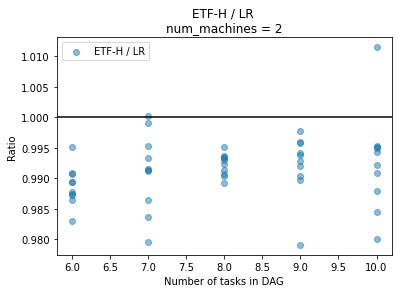

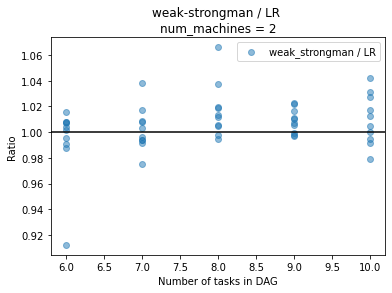

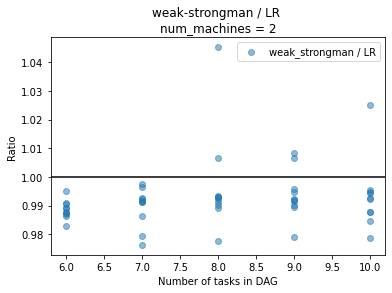

In [5]:
plt.scatter(df_test["num_tasks"], df_test["ETF-H_cost"]  / df_test["LR_cost"], label='ETF-H / LR', alpha=0.5)
plt.axhline(1,c="k")
plt.title("ETF-H / LR \nnum_machines = " + str(num_machines))
plt.xlabel("Number of tasks in DAG")
plt.ylabel("Ratio")
plt.legend()
plt.show()

plt.scatter(df_test["num_tasks"], df_test["weak_strongman_cost"] / df_test["LR_cost"] , label='weak_strongman / LR', alpha=0.5)
plt.axhline(1,c="k")
plt.title("weak-strongman / LR \nnum_machines = " + str(num_machines))
plt.xlabel("Number of tasks in DAG")
plt.ylabel("Ratio")
plt.legend()
plt.show()


plt.scatter(df_test["num_tasks"], df_test["RLP_cost"] / df_test["LR_cost"] , label='weak_strongman / LR', alpha=0.5)
plt.axhline(1,c="k")
plt.title("weak-strongman / LR \nnum_machines = " + str(num_machines))
plt.xlabel("Number of tasks in DAG")
plt.ylabel("Ratio")
plt.legend()
plt.show()